# PyTorch Water Pixel Semantic Segmentation

### Procedure
* Preprocess our 4km x 4km labeled Sentinel-2 satellite data into 64 x 64 pixel tiles.
* Then split the dataset into training testing and validation sets and normalize all channel values using the mean and std on the training set.
* We will then input our preprocessed data into a PyTorch UNet model for learning water semantic segmentation.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from glob import glob
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from pathlib import Path
import re
import sys
from random import Random

### Dataset Preprocessing

Our Sentinel-2 images come in 4km x 4km tiles that is roughly 400 x 400 pixels in shape. For training our model, we will want to preprocess our image data into 64 x 64 tiles first.

Methods:
* First we tried a discrete tiling method where imposed a grid with 64 x 64 cells onto the 4km by 4km image. However, when we ran the model using discrete tiles, we observed that the model did not undergo significant learning from the data. This is likely because this method not only produced a small dataset, but it also split water bodies at odd places, resulting in the loss of information.
* To solve this problem, we used a **random cropping method** that randomly sampled hundreds of 64 x 64 tiles from each image to ensure that every part of the waterbody is represented in the data, and also to augment our dataset from less than a thousand to tens of thousands for the model to learn on.

In [2]:
import logging

logger = logging.getLogger('preprocessing')
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(formatter)
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)
logger.propagate = False

In [2]:
train_labels = ["label_20150919_20150917_496_811.tif", "label_20150919_20150917_497_812.tif", "label_20151112_20151109_472_940.tif", "label_20151112_20151109_473_939.tif", "label_20151112_20151109_473_940.tif", 
         "label_20151112_20151109_473_941.tif", "label_20151112_20151109_474_942.tif", "label_20160314_20160311_451_838.tif", "label_20160314_20160311_451_839.tif", "label_20160307_20160311_452_846.tif",
         "label_20160314_20160311_452_845.tif"]
test_labels = ["label_20150919_20150917_496_812.tif", "label_20150919_20150917_497_811.tif", "label_20151112_20151109_474_941.tif", "label_20151112_20151109_485_960.tif", "label_20160314_20160311_452_843.tif"]

In [15]:
def random_crop(label_names, num_samples, typ="train", sample_dir='samples_200_5_4_35/', label_dir='labels/', crop_size=64, seed=433002):
    """For image segmentation task, we randomly crop our large tiles into num_samples smaller tiles."""
    Path(f'labels{crop_size}r_{typ}/').mkdir(parents=True, exist_ok=True)
    Path(f'samples{crop_size}r_{typ}/').mkdir(parents=True, exist_ok=True)

    rng = np.random.default_rng(seed)

    for label_file in label_names:
        p = re.compile('label_(\d{8})_(.+).tif')
        m = p.search(label_file)

        if m:
            tile_date = m.group(1)
            eid = m.group(2)
        else:
            logger.info(f'Skipping {label_file}...')
            continue

        with rasterio.open(label_dir + label_file) as src:
            label_raster = src.read([1, 2, 3])
            # if label has any values != 0 or 255 then print to log!
            if np.any((label_raster > 0) & (label_raster < 255)):
                logger.debug(f'{label_file} values are not 0 or 255.')
                
            label_binary = np.where(label_raster[0] != 0, 1, 0)

            HEIGHT = src.height
            WIDTH = src.width

        tci_file = sample_dir + f'{eid}/tci_{tile_date}_{eid}.tif'
        b08_file = sample_dir + f'{eid}/b08_{tile_date}_{eid}.tif'
        ndwi_file = sample_dir + f'{eid}/ndwi_{tile_date}_{eid}.tif'

        with rasterio.open(tci_file) as src:
            tci_raster = src.read()

        with rasterio.open(b08_file) as src:
            b08_raster = src.read()

        with rasterio.open(ndwi_file) as src:
            ndwi_raster = src.read()

        # choose n random coordinates within the tile
        sampled = 0
        while sampled < num_samples:
            x = int(rng.uniform(0, HEIGHT - crop_size))
            y = int(rng.uniform(0, WIDTH - crop_size))

            # check if already completed
            if Path(f'samples{crop_size}r_{typ}/sample_{tile_date}_{eid}_{x}_{y}.tif').exists():
                continue

            tci_tile = tci_raster[:, x : x + crop_size, y : y + crop_size]

            # if contains missing values, toss out and resample
            if np.any(tci_tile == 0):
                continue

            tci_tile = (tci_tile / 255).astype(np.float32)
            b08_tile = b08_raster[:, x : x + crop_size, y : y + crop_size]
            b08_tile = b08_tile.astype(np.float32)

            ndwi_tile = ndwi_raster[:, x : x + crop_size, y : y + crop_size]
            ndwi_tile = ndwi_tile.astype(np.float32)

            label_tile = label_binary[x : x + crop_size, y : y + crop_size]
            label_tile = label_tile.astype(np.uint8)

            stacked_tile = np.vstack((tci_tile, b08_tile, ndwi_tile), dtype=np.float32)

            # save 64 x 64 tile to tif file
            with rasterio.open(f'samples{crop_size}r_{typ}/sample_{tile_date}_{eid}_{x}_{y}.tif', 'w', driver='Gtiff', count=5, height=crop_size, width=crop_size, dtype=np.float32) as dst:
                dst.write(stacked_tile)
                    
            with rasterio.open(f'labels{crop_size}r_{typ}/label_{tile_date}_{eid}_{x}_{y}.tif', 'w', driver='Gtiff', count=1, height=crop_size, width=crop_size, dtype=np.uint8) as dst:
                dst.write(label_tile, 1)
                
            sampled += 1

In [8]:
random_crop(train_labels, 1000, typ="train", seed=433300)

In [5]:
random_crop(test_labels, 1000, typ="test", seed=433400)

/home/dma/miniconda3/envs/floodmapsgpu2/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dma/miniconda3/envs/floodmapsgpu2/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [3]:
def discrete_tiles(sample_dir='samples_200_5_4_35/', label_dir='labels/', keep_old=True):
    """Generates 64 x 64 image and label patches from sample dataset by iterating over the larger grid
    in 64 by 64 increments."""
    Path('labels64d/').mkdir(parents=True, exist_ok=True)
    Path('samples64d/').mkdir(parents=True, exist_ok=True)

    for label_file in glob(label_dir + '*.tif'):
        p = re.compile('label_(\d{8})_(.+).tif')
        m = p.search(label_file)

        if m:
            tile_date = m.group(1)
            eid = m.group(2)
        else:
            logger.info(f'Skipping {label_file}...')
            continue

        with rasterio.open(label_file) as src:
            label_raster = src.read([1, 2, 3])
            # if label has any values != 0 or 255 then print to log!
            if np.any((label_raster > 0) & (label_raster < 255)):
                logger.debug(f'{label_file} values are not 0 or 255.')
                
            label_binary = np.where(label_raster[0] != 0, 1, 0)

            HEIGHT = src.height
            WIDTH = src.width

        tci_file = sample_dir + f'{eid}/tci_{tile_date}_{eid}.tif'
        b08_file = sample_dir + f'{eid}/b08_{tile_date}_{eid}.tif'
        ndwi_file = sample_dir + f'{eid}/ndwi_{tile_date}_{eid}.tif'

        with rasterio.open(tci_file) as src:
            tci_raster = src.read()

        with rasterio.open(b08_file) as src:
            b08_raster = src.read()

        with rasterio.open(ndwi_file) as src:
            ndwi_raster = src.read()
            
        # break each sample up into 64 x 64 tiles and save
        for i in range(0, HEIGHT // 64):
            for j in range(0, WIDTH // 64):
                if keep_old and Path(f'samples64/sample_{tile_date}_{eid}_{i}_{j}.tif').exists() \
                    and Path(f'labels64/label_{tile_date}_{eid}_{i}_{j}.tif').exists():
                    continue
                    
                tci_tile = tci_raster[:, i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64]
                # skip if missing values exist
                if np.count_nonzero(tci_tile[0] == 0) > 0:
                    logger.info(f'Skipping tile {i}, {j} of {label_file} due to missing values.')
                    continue
                tci_tile = (tci_tile / 255).astype(np.float32)

                b08_tile = b08_raster[:, i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64]
                b08_tile = b08_tile.astype(np.float32)

                ndwi_tile = ndwi_raster[:, i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64]
                ndwi_tile = ndwi_tile.astype(np.float32)

                label_tile = label_binary[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64]
                label64 = label_tile.astype(np.uint8)

                tile64 = np.vstack((tci_tile, b08_tile, ndwi_tile), dtype=np.float32)

                # save 64 x 64 tile to tif file
                with rasterio.open(f'samples64/sample_{tile_date}_{eid}_{i}_{j}.tif', 'w', driver='Gtiff', count=5, height=64, width=64, dtype=np.float32) as dst:
                    dst.write(tile64)
                    
                with rasterio.open(f'labels64/label_{tile_date}_{eid}_{i}_{j}.tif', 'w', driver='Gtiff', count=1, height=64, width=64, dtype=np.uint8) as dst:
                    dst.write(label64, 1)

In [4]:
discrete_tiles(keep_old=True)

/home/dma/miniconda3/envs/floodmaps/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dma/miniconda3/envs/floodmaps/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


2023-12-29 13:37:37,315 - preprocessing - INFO - Skipping tile 0, 0 of labels/label_20160314_20160311_451_838.tif due to 1.0 NA percentage.
2023-12-29 13:37:37,320 - preprocessing - INFO - Skipping tile 0, 1 of labels/label_20160314_20160311_451_838.tif due to 0.556396484375 NA percentage.
2023-12-29 13:37:37,328 - preprocessing - INFO - Skipping tile 1, 0 of labels/label_20160314_20160311_451_838.tif due to 1.0 NA percentage.
2023-12-29 13:37:37,336 - preprocessing - INFO - Skipping tile 2, 0 of labels/label_20160314_20160311_451_838.tif due to 0.9931640625 NA percentage.
2023-12-29 13:37:37,344 - preprocessing - INFO - Skipping tile 3, 0 of labels/label_20160314_20160311_451_838.tif due to 0.781494140625 NA percentage.
2023-12-29 13:37:37,352 - preprocessing - INFO - Skipping tile 4, 0 of labels/label_20160314_20160311_451_838.tif due to 0.53271484375 NA percentage.


### Create Custom Dataset and DataLoader

In [3]:
# Create custom Dataset objects to input into DataLoader!!!
class FloodSampleDataset(Dataset):
    def __init__(self, sample_dir, labels_dir, typ="train", transform=None, random_flip=True, seed=41000):
        self.sample_dir = sample_dir
        self.labels_dir = labels_dir
        self.labels_path = glob(labels_dir + '/label_*.tif')
        self.typ = typ
        self.transform = transform
        self.random_flip = random_flip
        self.seed = seed
        
        if random_flip:
            self.random = Random(seed)

    def __len__(self):
        return len(self.labels_path)

    @staticmethod
    def read_image(filename):
        """Reads a TIF image into a N x H x W Tensor given N channels."""
        with rasterio.open(filename) as src:
            raster = src.read()
    
        tensor = torch.from_numpy(raster)
        return tensor
        
    def __getitem__(self, idx):
        label_path = self.labels_path[idx]
        p = re.compile('label_(.+\.tif)')
        m = p.search(label_path)

        if m:
            sample_path = self.sample_dir + '/sample_' + m.group(1)
            image = self.read_image(sample_path)
            label = self.read_image(label_path) # ensure label tensor is of type torch.uint8
        else:
            raise Exception("Improper label path name")

        if self.transform:
            image = self.transform(image)

        if self.random_flip and self.typ == "train":
            image, label = self.hv_random_flip(image, label)
            
        return image, label

    def hv_random_flip(self, x, y):
        # Random horizontal flipping
        if self.random.random() > 0.5:
            x = torch.flip(x, [2])
            y = torch.flip(y, [2])
            
        # Random vertical flipping
        if self.random.random() > 0.5:
            x = torch.flip(x, [1])
            y = torch.flip(y, [1])
            
        return x, y

class FloodSampleMeanStd(Dataset):
    def __init__(self, labels, sample_dir='samples_200_5_4_35/', label_dir='labels/'):
        self.labels = labels
        self.sample_dir = sample_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.labels)

    @staticmethod
    def stack_channels(tci_file, b08_file, ndwi_file):
        """Reads multiple TIF images and stacks them into N x M shape given N channels."""
        with rasterio.open(tci_file) as src:
            tci_raster = src.read()
            tci_raster = (tci_raster / 255).reshape((3, -1))

        with rasterio.open(b08_file) as src:
            b08_raster = src.read().reshape((1, -1))

        with rasterio.open(ndwi_file) as src:
            ndwi_raster = src.read().reshape((1, -1))

        stack = np.vstack((tci_raster, b08_raster, ndwi_raster), dtype=np.float32)
        tensor = torch.from_numpy(stack)
        return tensor
        
    def __getitem__(self, idx):
        label_path = self.label_dir + self.labels[idx]
        p = re.compile('label_(\d{8})_(.+).tif')
        m = p.search(label_path)

        if m:
            tile_date = m.group(1)
            eid = m.group(2)
            tci_file = self.sample_dir + f'{eid}/tci_{tile_date}_{eid}.tif'
            b08_file = self.sample_dir + f'{eid}/b08_{tile_date}_{eid}.tif'
            ndwi_file = self.sample_dir + f'{eid}/ndwi_{tile_date}_{eid}.tif'
            
            image = self.stack_channels(tci_file, b08_file, ndwi_file)
        else:
            raise Exception("Improper label path name")
            
        return image

With the dataset loaded, we want to calculate the mean and standard deviation for each channel of the training set and standardize the entire dataset.

Using our calculation mean and stds, transform data to 0 mean and unit std across all channels:

**Discrete Mean & Std**

In [ ]:
# discrete
val_percent = 0.25
dataset = FloodSampleDataset('samples64d', 'labels64d', typ="all", random_flip=False)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))

loader = DataLoader(train_set,
                    batch_size=10,
                    num_workers=0,
                    shuffle=False)

In [ ]:
# discrete - calculate total mean and std for each channel not including missing values
pixel_count = 0
sum = torch.zeros(5, dtype=torch.float64)
for samples, _ in loader:
    # first stack all feature values from batch together
    channels = samples.size(1)
    samples = torch.transpose(samples, 0, 1)
    samples = samples.reshape(channels, -1)

    # mask out missing values and calculate mean for each channel
    mask = (samples[0] != 0)
    pixel_count += mask.sum()
    for i in range(channels):
        sum[i] += samples[i][mask].sum()
mean = sum / pixel_count

# add up variance for each channel not including missing values
tot_var = torch.zeros(5, dtype=torch.float64)
for samples, _ in loader:
    # first stack all feature values from batch together
    channels = samples.size(1)
    samples = torch.transpose(samples, 0, 1)
    samples = samples.reshape(channels, -1)

    mask = (samples[0] != 0)
    for i in range(channels):
        tot_var[i] += ((samples[i][mask] - mean[i]) ** 2).sum()
std = torch.sqrt(tot_var / (pixel_count - 1))

print('Training channel means:', mean)
print('Training channel stds:', std)

standardize = transforms.Compose([transforms.Normalize(mean, std)])

In [ ]:
# discrete
dataset.transform = standardize

**Random Crop Mean & Std**

In [10]:
# random_crop
def channel_collate(batch):
    # concatenate channel wise for all samples in batch
    samples = torch.cat(batch, 1)
    return samples

train_mean_std = FloodSampleMeanStd(train_labels)
train_set = FloodSampleDataset('samples64r_train', 'labels64r_train', typ="train")
val_set = FloodSampleDataset('samples64r_test', 'labels64r_test', typ="test")

loader = DataLoader(train_mean_std,
                    batch_size=10,
                    num_workers=0,
                    collate_fn=channel_collate,
                    shuffle=False)

In [11]:
# random crop - calculate total mean and std for each channel not including missing values
pixel_count = 0
sum = torch.zeros(5, dtype=torch.float64)
for samples in loader:
    # mask out missing values and calculate mean for each channel
    channels = samples.size(0)
    mask = (samples[0] != 0)
    pixel_count += mask.sum()
    for i in range(channels):
        sum[i] += samples[i][mask].sum()
mean = sum / pixel_count

# add up variance for each channel not including missing values
tot_var = torch.zeros(5, dtype=torch.float64)
for samples in loader:
    # first stack all feature values from batch together
    channels = samples.size(0)
    mask = (samples[0] != 0)
    for i in range(channels):
        tot_var[i] += ((samples[i][mask] - mean[i]) ** 2).sum()
std = torch.sqrt(tot_var / (pixel_count - 1))

print('Training channel means:', mean)
print('Training channel stds:', std)

standardize = transforms.Compose([transforms.Normalize(mean, std)])

Training channel means: tensor([ 2.1087e-01,  2.3580e-01,  1.6223e-01,  1.5950e+03, -2.2037e-01],
       dtype=torch.float64)
Training channel stds: tensor([1.9434e-01, 1.8074e-01, 1.6635e-01, 1.1922e+03, 5.1990e-01],
       dtype=torch.float64)


In [12]:
# random crop
train_set.transform = standardize
val_set.transform = standardize

Let's take a look at some of our 64 x 64 tiles in the training dataset.

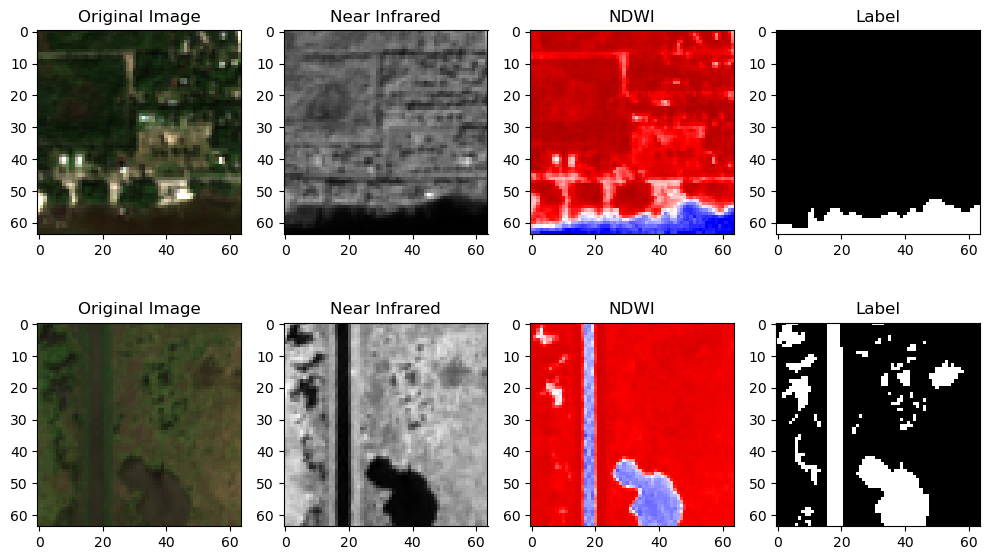

In [123]:
plt.figure(figsize=(10, 6))
for i in range(0,2):
    image, label = train_set[i]
    example = image.numpy().transpose((1, 2, 0))
    example = std * example + mean
    tci = example[:, :, :3]
    tci = np.clip(tci, 0, 1)
    b08 = example[:, :, 3]
    ndwi = example[:, :, 4]
    
    label = label.numpy().transpose((1, 2, 0))
    
    plt.subplot(2,4,4*i+1)
    plt.imshow(tci)
    plt.title('Original Image')

    plt.subplot(2,4,4*i+2)
    plt.imshow(b08, cmap='gray')
    plt.title('Near Infrared')

    plt.subplot(2,4,4*i+3)
    plt.imshow(ndwi, cmap='seismic_r', vmin=-1, vmax=1)
    plt.title('NDWI')

    plt.subplot(2,4,4*i+4)
    plt.imshow(label, cmap='gray', vmin=0, vmax=1)
    plt.title('Label')
    
plt.tight_layout()
plt.show()

Now with our data preprocessed and standardized, we are ready to train our model!

### Water Stratification

An important element in our data is how much water is represented by our patches. We want to make sure the model has sufficient examples of water to learn from. Let's look at the average percent wet and percent dry for the training data patches.

In [42]:
def percent_water_dry(label):
    tot_pixels = label.size
    water_pixels = np.count_nonzero(label)
    percent_water = water_pixels / tot_pixels
    percent_dry = 1 - percent_water
    return percent_water, percent_dry

def percentage_by_image(label_names, label_dir='labels/'):
    print("Percentage water by image:")
    for label_file in label_names:
        p = re.compile('label_(\d{8})_(.+).tif')
        m = p.search(label_file)

        if m:
            tile_date = m.group(1)
            eid = m.group(2)

        with rasterio.open(label_dir + label_file) as src:
            label_raster = src.read([1, 2, 3])
            # if label has any values != 0 or 255 then print to log!
            if np.any((label_raster > 0) & (label_raster < 255)):
                logger.debug(f'{label_file} values are not 0 or 255.')
                
            label_binary = np.where(label_raster[0] != 0, 1, 0)
        percent_water, percent_dry = percent_water_dry(label_binary)
        print(eid, f"water {percent_water * 100}%, dry {percent_dry * 100}%")
    
def percentage_by_patch(labels_dir="labels64r_train/"):
    water_sum = 0
    dry_sum = 0
    lst = glob(labels_dir + "label_*.tif")
    for filename in lst:
        with rasterio.open(filename) as src:
            raster = src.read()
        percent_water, percent_dry = percent_water_dry(raster)
        water_sum += percent_water
        dry_sum += percent_dry

    avg_water_percent = water_sum / len(lst)
    avg_dry_percent = dry_sum / len(lst)
    print(f"Percentage avg by patch: water {avg_water_percent * 100}%, dry {avg_dry_percent * 100}%")

In [41]:
percentage_by_image(train_labels, label_dir='labels/')

Percentage water by image:
20150917_496_811 water 29.829704075935233%, dry 70.17029592406476%
20150917_497_812 water 85.5522269466993%, dry 14.447773053300693%
20151109_472_940 water 90.77903498504357%, dry 9.220965014956429%
20151109_473_939 water 63.37607161003665%, dry 36.62392838996335%
20151109_473_940 water 16.931113712229592%, dry 83.06888628777041%
20151109_473_941 water 1.7183638964754844%, dry 98.28163610352452%
20151109_474_942 water 36.31323969306802%, dry 63.68676030693199%
20160311_451_838 water 0.3796441512086961%, dry 99.6203558487913%
20160311_451_839 water 0.9539776107295441%, dry 99.04602238927046%
20160311_452_846 water 1.4826795335049874%, dry 98.51732046649502%
20160311_452_845 water 15.073457818551617%, dry 84.92654218144838%


In [43]:
percentage_by_image(test_labels, label_dir='labels/')

Percentage water by image:
20150917_496_812 water 50.519692479491475%, dry 49.480307520508525%
20150917_497_811 water 92.55143237555298%, dry 7.448567624447023%
20151109_474_941 water 50.17828499588156%, dry 49.82171500411844%
20151109_485_960 water 65.83897870502821%, dry 34.161021294971796%
20160311_452_843 water 0.256313403842003%, dry 99.743686596158%


In [44]:
percentage_by_patch(labels_dir="labels64r_train/")

Percentage avg by patch: water 31.700068803267044%, dry 68.29993119673296%


In [39]:
percentage_by_patch(labels_dir="labels64r_test/")

Percentage water by patch: 0.53412333984375


### UNet Implementation

In [7]:
torch.cuda.is_available()

True

In [6]:
from torch import nn
from torcheval.metrics import BinaryAccuracy

In [7]:
class DoubleConv2d(nn.Module):
    """Convolution layer followed by batch normalization and ReLU, done twice."""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UpConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.drop = nn.Dropout(p=dropout)
        self.conv = DoubleConv2d(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x3 = torch.cat([x1, x2], dim=1)
        x4 = self.drop(x3)
        return self.conv(x4)

class UNet(nn.Module):
    def __init__(self, n_channels, dropout=0.5):
        super().__init__()
        self.n_channels = n_channels

        self.conv1 = (DoubleConv2d(n_channels, 16))
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(p=dropout)

        self.conv2 = (DoubleConv2d(16, 32))
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(p=dropout)

        self.conv3 = (DoubleConv2d(32, 64))
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(p=dropout)

        self.conv4 = (DoubleConv2d(64, 128))
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(p=dropout)

        self.convm = (DoubleConv2d(128, 256))

        self.upconv4 = UpConv2d(256, 128, dropout=dropout)
        self.upconv3 = UpConv2d(128, 64, dropout=dropout)
        self.upconv2 = UpConv2d(64, 32, dropout=dropout)
        self.upconv1 = UpConv2d(32, 16, dropout=dropout)

        # output layer
        self.out = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        out = self.pool1(x1)
        out = self.drop1(out)
        x2 = self.conv2(out)
        out = self.pool2(x2)
        out = self.drop2(out)
        x3 = self.conv3(out)
        out = self.pool3(x3)
        out = self.drop3(out)
        x4 = self.conv4(out)
        out = self.pool4(x4)
        out = self.drop4(out)
        x5 = self.convm(out)

        x = self.upconv4(x5, x4)
        x = self.upconv3(x, x3)
        x = self.upconv2(x, x2)
        x = self.upconv1(x, x1)
        logits = self.out(x)
        
        return logits

Model summary:

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
unet = UNet(5, dropout=0.2).to(device)

Using cuda device


In [9]:
print(f"Model structure: {unet}\n\n")

Model structure: UNet(
  (conv1): DoubleConv2d(
    (double_conv): Sequential(
      (0): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): DoubleConv2d(
    (double_conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4)

Let's train our UNet model...

In [11]:
import wandb
from datetime import datetime

In [12]:
wandb.login()

wandb: Currently logged in as: davidma. Use `wandb login --relogin` to force relogin


True

In [13]:
# get our optimizer and metrics
def train_loop(dataloader, model, device, loss_fn, optimizer):
    running_loss = 0.0
    num_batches = len(dataloader)
    metric = BinaryAccuracy(threshold=0.5)

    model.train()
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        logits = model(X)

        loss = loss_fn(logits, y.float())
        loss.backward()
        optimizer.step()

        metric.update(nn.functional.sigmoid(logits).flatten(), y.float().flatten())
        running_loss += loss.item()

    # wandb tracking loss and accuracy per epoch
    epoch_accuracy = metric.compute()
    epoch_loss = running_loss / num_batches
    wandb.log({"train accuracy": epoch_accuracy, "train loss": epoch_loss})

    return epoch_loss

def test_loop(dataloader, model, device, loss_fn):
    running_vloss = 0.0
    num_batches = len(dataloader)
    metric = BinaryAccuracy(threshold=0.5)
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            logits = model(X)
            running_vloss += loss_fn(logits, y.float()).item()
            metric.update(nn.functional.sigmoid(logits).flatten(), y.float().flatten())

    epoch_vaccuracy = metric.compute()
    epoch_vloss = running_vloss / num_batches
    wandb.log({"val accuracy": epoch_vaccuracy, "val loss": epoch_vloss})

    return epoch_vloss

def train(train_set, val_set, model, device, dropout=0.5, epochs=5, batch_size=16, learning_rate=1e-5, 
          save='model', project="FloodSamplesUNet"):
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f'''Starting training:
        Date:            {timestamp}
        Dropout:         {dropout}
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {len(train_set)}
        Validation size: {len(val_set)}
        Device:          {device}
    ''')

    # log via wandb
    wandb.init(
        project=project,
        config={
        "learning_rate": learning_rate,
        "architecture": "CNN",
        "dropout": dropout,
        "dataset": "Sentinel2",
        "epochs": epochs,
        "batch_size": batch_size,
        "val_percent": len(val_set) / (len(train_set) + len(val_set))
        }
    )

    # initialize model
    unet = UNet(5, dropout=dropout).to(device)
    
    # initialize loss function
    loss_fn = nn.BCEWithLogitsLoss()

    # optimizer and scheduler for reducing learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

    # make DataLoader
    train_loader = DataLoader(train_set,
                             batch_size=batch_size,
                             num_workers=0,
                             shuffle=True,
                             drop_last=False)
    
    val_loader = DataLoader(val_set,
                            batch_size=batch_size,
                            num_workers=0,
                            shuffle=True,
                            drop_last=False)

    # TRAIN AND TEST LOOP IS PER EPOCH!!!
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        # train loop
        avg_loss = train_loop(train_loader, model, device, loss_fn, optimizer)

        # at the end of each training epoch compute validation
        avg_vloss = test_loop(val_loader, model, device, loss_fn)
        scheduler.step(avg_vloss)

        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Save our model
    PATH = 'models/' + save + '.pth'
    torch.save(model.state_dict(), PATH)

    wandb.finish()

**Discrete Model**

In [ ]:
# training
train(train_set, val_set, unet, device, dropout=0.2, epochs=40, batch_size=10, learning_rate=1e-5, save='model4')

Starting training:
        Date:            2024-01-04 13:00:32
        Dropout:         0.2
        Epochs:          40
        Batch size:      10
        Learning rate:   1e-05
        Training size:   437
        Validation size: 145
        Device:          cpu
    


Epoch 1
-------------------------------


/home/dma/miniconda3/envs/floodmaps/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dma/miniconda3/envs/floodmaps/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


LOSS train 0.66782900149172 valid 0.7150610605875651
Epoch 2
-------------------------------
LOSS train 0.644094468517737 valid 0.7256142934163411
Epoch 3
-------------------------------
LOSS train 0.6186162802306089 valid 0.7185066103935241
Epoch 4
-------------------------------
LOSS train 0.5956919965418902 valid 0.7230922102928161
Epoch 5
-------------------------------
LOSS train 0.5730940293182026 valid 0.7131059686342875
Epoch 6
-------------------------------
LOSS train 0.5458260971036825 valid 0.7306442379951477
Epoch 7
-------------------------------
LOSS train 0.5261421047828414 valid 0.7314088225364686
Epoch 8
-------------------------------
LOSS train 0.5128056501800363 valid 0.7173309206962586
Epoch 9
-------------------------------
LOSS train 0.4910169995643876 valid 0.7216413696606954
Epoch 10
-------------------------------
LOSS train 0.48333114927465265 valid 0.7079645117123922
Epoch 11
-------------------------------
LOSS train 0.47405021434480493 valid 0.71694175402

In [36]:
# plot prediction results for test data
pred_unet = UNet(5)
pred_unet.load_state_dict(torch.load('models/model2.pth'))

<All keys matched successfully>

Validation loss is high and validation accuracy is really low compared to the training. Shows that the model did not learn anything useful from the data through our discrete tiling method. The plots of predictions made on both the training and validation (which we omit here) also point to the same conclusion.

**Random Crop Model**

In [14]:
# training
train(train_set, val_set, unet, device, dropout=0.2, epochs=35, batch_size=2048, learning_rate=1e-5, 
      save='model7', project="FloodSamplesUNetRC")

Starting training:
        Date:            2024-01-17 21:04:11
        Dropout:         0.2
        Epochs:          35
        Batch size:      2048
        Learning rate:   1e-05
        Training size:   11000
        Validation size: 5000
        Device:          cuda
    


Epoch 1
-------------------------------


/home/dma/miniconda3/envs/floodmapsgpu2/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dma/miniconda3/envs/floodmapsgpu2/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


LOSS train 0.6571251451969147 valid 0.6958343784014384
Epoch 2
-------------------------------
LOSS train 0.6475897232691447 valid 0.6979183952013651
Epoch 3
-------------------------------
LOSS train 0.6381829480330149 valid 0.6987124681472778
Epoch 4
-------------------------------
LOSS train 0.6276407043139139 valid 0.694653312365214
Epoch 5
-------------------------------
LOSS train 0.6190257966518402 valid 0.6832809646924337
Epoch 6
-------------------------------
LOSS train 0.6094261805216471 valid 0.6622604330380758
Epoch 7
-------------------------------
LOSS train 0.6003225743770599 valid 0.6400872468948364
Epoch 8
-------------------------------
LOSS train 0.5913306872049967 valid 0.6175804336865743
Epoch 9
-------------------------------
LOSS train 0.5827866494655609 valid 0.5996444821357727
Epoch 10
-------------------------------
LOSS train 0.57426189382871 valid 0.5834041436513265
Epoch 11
-------------------------------
LOSS train 0.5663775503635406 valid 0.5686183571815

train accuracy,▁▂▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████████████
train loss,██▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val accuracy,▁▁▁▁▂▃▄▄▅▆▆▇▇▇▇▇███████████████████
val loss,█████▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train accuracy,0.94827
train loss,0.44594
val accuracy,0.95344
val loss,0.37197


Plot performance on training and validation sets:

In [4]:
def prediction_plots(model, dataset, n, seed=230):
    rd = Random(seed)
    m = rd.randint(0, len(dataset) - n - 1)
    for i in range(0,n):
        # pick random data point in dataset
        X, y = dataset[m + i]
        logits = model(X.unsqueeze(0))
        pred_y = torch.where(nn.functional.sigmoid(logits) > 0.9, 1.0, 0.0)
        
        tci = X.numpy().transpose((1, 2, 0))
        tci = std * tci + mean
        tci = tci[:, :, :3]
        tci = np.clip(tci, 0, 1)
        actual_label = y.numpy()[0]
        pred_label = pred_y.numpy()[0][0]
        
        plt.subplot(n,3,3*i+1)
        plt.imshow(tci)
        plt.title('Original Image')
    
        plt.subplot(n,3,3*i+2)
        plt.imshow(actual_label, cmap='gray', vmin=0, vmax=1)
        plt.title('Actual Label')
    
        plt.subplot(n,3,3*i+3)
        plt.imshow(pred_label, cmap='gray', vmin=0, vmax=1)
        plt.title('Predicted Label')
        
    plt.tight_layout()
    plt.show()

pred_unet_rc = UNet(5, dropout=0.2).to("cpu")
pred_unet_rc.load_state_dict(torch.load('models/model7.pth'))

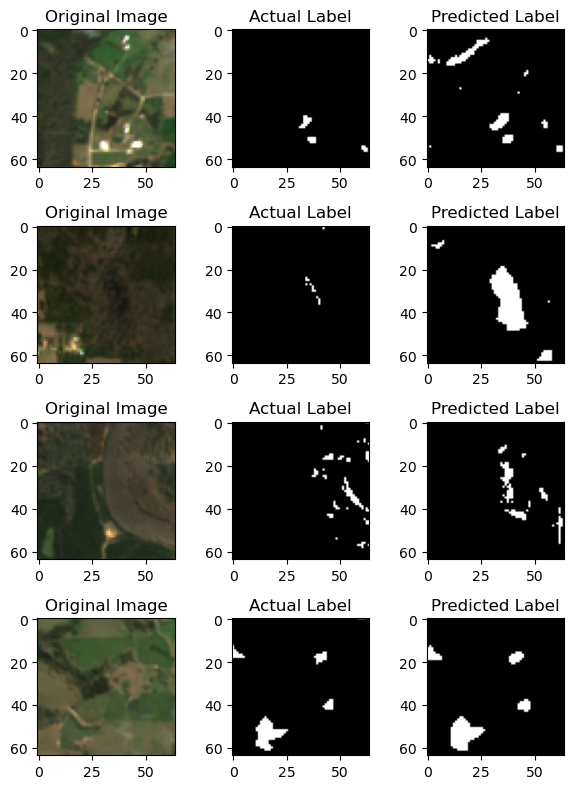

In [40]:
plt.figure(figsize=(6, 8))
prediction_plots(pred_unet_rc, train_set, 4)

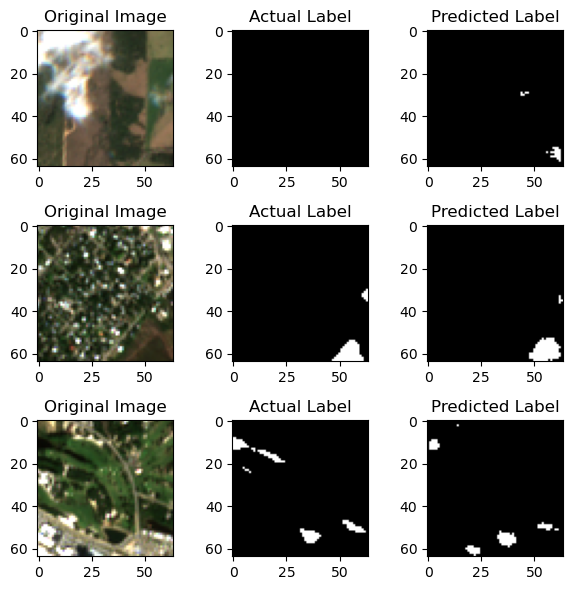

In [73]:
plt.figure(figsize=(6, 6))
prediction_plots(pred_unet_rc, val_set, 3)

With the random cropping we begin to see some significantly learning taking place. Still some work needs to be done regarding tuning and adding stratification of water vs. non-water patches, but this is a big step in the right direction.